In [ ]:

import re

import json

import torch

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from collections import Counter

from pathlib import Path


#  =======   Этап 1. Подготовка данных  ======== 


def preprocess_text(text: str) -> str:

    """

    Очищает текст от лишних символов:

    - убирает пунктуацию, цифры, спецсимволы

    - приводит к нижнему регистру

    - удаляет лишние пробелы

    """

    text = re.sub(r"[^а-яА-ЯёЁa-zA-Z\s]", "", text)

    text = text.lower()

    text = re.sub(r"\s+", " ", text).strip()

    return text





class TextDataset(Dataset):

    """Простой датасет: хранит закодированные тексты"""



    def __init__(self, encoded_texts, max_len=50):

        self.data = encoded_texts

        self.max_len = max_len



    def __len__(self):

        return len(self.data)



    def __getitem__(self, idx):

        # Получаем один текст и дополняем нулями до max_len

        x = self.data[idx][:self.max_len]

        if len(x) < self.max_len:

            x = x + [0] * (self.max_len - len(x))

        return torch.tensor(x, dtype=torch.long)





def prepare_dataloaders(data_path="data/tweets.txt", batch_size=32, max_len=20):

    """

    Главная функция: готовит данные и возвращает

    train_loader, val_loader, test_loader, vocab, inv_vocab.

    """

    BASE_DIR = Path.cwd()

    file_path = BASE_DIR / data_path



    if not file_path.exists():

        raise FileNotFoundError(f"Dataset file not found: {file_path}")



    print("Используется файл:", file_path)



    # 1) Загружаем тексты

    with open(file_path, "r", encoding="utf-8") as f:

        texts = [line.strip() for line in f if line.strip()]



    if len(texts) == 0:

        raise ValueError("Файл датасета пуст или не содержит непустых строк.")



    print(f"Загружено {len(texts)} текстов. Пример:")

    print(texts[0])



    # 2) Предобработка

    clean_texts = [preprocess_text(t) for t in texts]

    tokenized = [t.split() for t in clean_texts]



    # 3) Сохраняем промежуточные файлы (опционально)

    output_dir = BASE_DIR / "data"

    output_dir.mkdir(exist_ok=True)



    with open(output_dir / "clean_texts.txt", "w", encoding="utf-8") as f:

        for line in clean_texts:

            f.write(line + "\n")



    with open(output_dir / "tokenized_texts.json", "w", encoding="utf-8") as f:

        json.dump(tokenized, f, ensure_ascii=False, indent=2)



    # 4) Создаём словарь (vocab) — локальная переменная внутри функции

    word_counts = Counter(word for text in tokenized for word in text)

    vocab = {word: i + 2 for i, (word, _) in enumerate(word_counts.items())}

    vocab["<PAD>"] = 0

    vocab["<UNK>"] = 1

    inv_vocab = {i: w for w, i in vocab.items()}



    with open(output_dir / "vocab.json", "w", encoding="utf-8") as f:

        json.dump(vocab, f, ensure_ascii=False, indent=2)



    # 5) Кодируем тексты

    def encode(tokens):

        return [vocab.get(word, vocab["<UNK>"]) for word in tokens]



    encoded_texts = [encode(t) for t in tokenized]



    with open(output_dir / "encoded_texts.json", "w", encoding="utf-8") as f:

        json.dump(encoded_texts, f)



    # 6) Делим данные

    train_texts, temp_texts = train_test_split(encoded_texts, test_size=0.2, random_state=42)

    val_texts, test_texts = train_test_split(temp_texts, test_size=0.5, random_state=42)



    # 7) Создаём Dataset’ы

    train_dataset = TextDataset(train_texts, max_len=max_len)

    val_dataset = TextDataset(val_texts, max_len=max_len)

    test_dataset = TextDataset(test_texts, max_len=max_len)



    # 8) DataLoader’ы

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



    print("\n✅ DataLoader’ы созданы корректно.")

    print(f"Train: {len(train_texts)} | Val: {len(val_texts)} | Test: {len(test_texts)}")



    # Возвращаем в фиксированном порядке

    return train_loader, val_loader, test_loader, vocab, inv_vocab





if __name__ == "__main__":

    # Быстрая проверка при запуске модуля напрямую

    train_loader, val_loader, test_loader, vocab, inv_vocab = prepare_dataloaders()

    for batch in train_loader:

        print(f"\nПример батча: форма {batch.shape}")

        print(batch)

        break

Используется файл: /home/ubuntu/tweets.txt
Загружено 1600498 текстов. Пример:
@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

✅ DataLoader’ы созданы корректно.
Train: 1280398 | Val: 160050 | Test: 160050

Пример батча: форма torch.Size([32, 20])
tensor([[ 84819,   1365,     16,  28947,     60,   6229,    425,    157,    263,
            269,     28, 717386, 717387,     60,    476,    299,  13845,    179,
            438,      0],
        [  1086,   1661,    533,   1206,     36,   5403,     44,    335,     30,
            247, 232391,   1205,      0,      0,      0,      0,      0,      0,
              0,      0],
        [ 59072,   3377,    140,     40,   1842,   2931,    132,  15441,    984,
             45,   1752,    430,    280,  21749,      0,      0,      0,      0,
              0,      0],
        [ 21978,     53,   2526,    593,      0,      0,      0,      0,      0,
              0,      0,      0,      0,

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ===============================

#   Этап 2. Модель на основе LSTM

# ===============================


class LSTMTextModel(nn.Module):

    def __init__(self, vocab_size, embed_dim=32, hidden_dim=32, num_layers=1):

        """
        vocab_size — размер словаря (количество уникальных токенов)

        embed_dim — размер эмбеддинга

        hidden_dim — размер скрытого состояния LSTM

        num_layers — количество слоёв LSTM

        """

        super(LSTMTextModel, self).__init__()


        # Векторные представления токенов

        self.embedding = nn.Embedding(vocab_size, embed_dim)


        # Основная рекуррентная часть — LSTM

        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)


        # Линейный слой для предсказания следующего токена

        self.fc = nn.Linear(hidden_dim, vocab_size)


    def forward(self, input_seq, hidden=None):

        """

        input_seq: [batch_size, seq_len] — входная последовательность токенов

        hidden: скрытые состояния (если передаются вручную)

        Возвращает:

            logits — предсказания по всем токенам (до softmax)

            hidden — новое скрытое состояние LSTM

        """

        embedded = self.embedding(input_seq)  # [batch, seq_len, embed_dim]

        lstm_out, hidden = self.lstm(embedded, hidden)  # [batch, seq_len, hidden_dim]

        logits = self.fc(lstm_out)  # [batch, seq_len, vocab_size]

        return logits, hidden


    @torch.no_grad()

    def generate(self, start_seq, next_tokens=10, temperature=1.0, device="cpu"):

        """

        Генерация последовательности токенов.

        start_seq: список токенов (начальная последовательность)

        next_tokens: сколько токенов нужно сгенерировать

        temperature: параметр "температуры" (чем больше, тем более случайные выборы)

        """

        self.eval()  # режим генерации (отключаем dropout и тд)

        generated = torch.tensor(start_seq, dtype=torch.long, device=device).unsqueeze(0)

        hidden = None


        for _ in range(next_tokens):

            logits, hidden = self.forward(generated, hidden)

            next_token_logits = logits[:, -1, :] / temperature  # берём последние логиты

            probs = F.softmax(next_token_logits, dim=-1)

            next_token = torch.multinomial(probs, num_samples=1)  # случайный выбор токена

            generated = torch.cat((generated, next_token), dim=1)



        return generated.squeeze(0).tolist()



In [ ]:
import torch

import torch.nn as nn

import torch.optim as optim

from tqdm import tqdm

from rouge_score import rouge_scorer

#  =======   Этап 3. Обучение модели  LSTM  ======== 


# === Настройка устройства (GPU) ===

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




# === Функция вычисления ROUGE ===

def compute_rouge(pred_texts, ref_texts):

    """

    Подсчитывает средние ROUGE-1 и ROUGE-2 между предсказанными и эталонными текстами.

    Используется для оценки качества текстовой генерации.

    """

    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2"], use_stemmer=True)

    rouge1, rouge2 = [], []



    for pred, ref in zip(pred_texts, ref_texts):

        scores = scorer.score(ref, pred)

        rouge1.append(scores["rouge1"].fmeasure)

        rouge2.append(scores["rouge2"].fmeasure)



    return sum(rouge1)/len(rouge1), sum(rouge2)/len(rouge2)





# === Основная функция обучения модели ===

def train_model(model, train_loader, val_loader, vocab, inv_vocab,

                num_epochs=1, lr=0.001, device="cpu", save_path="lstm_model.pth"):

    """

    Обучает LSTM-модель на тренировочных данных, оценивает на валидации и сохраняет веса.

    """



    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=lr)



    for epoch in range(num_epochs):

        model.train()

        total_loss = 0



        print(f"\n易 Эпоха {epoch+1}/{num_epochs}")



        # --- Цикл обучения ---

        for batch in tqdm(train_loader, desc="Обучение"):

            # batch — это батч предложений (тензор [batch_size, seq_len])

            inputs = batch[:, :-1].to(device)   # всё, кроме последнего токена

            targets = batch[:, 1:].to(device)   # всё, кроме первого токена



            optimizer.zero_grad()

            outputs, _ = model(inputs)



            # Переформатируем для функции потерь: [batch*seq, vocab_size]

            loss = criterion(outputs.reshape(-1, len(vocab)), targets.reshape(-1))

            loss.backward()

            optimizer.step()

            total_loss += loss.item()



        avg_loss = total_loss / len(train_loader)

        print(f"Средняя функция потерь (train): {avg_loss:.4f}")



        # --- Валидация после каждой эпохи ---

        model.eval()

        val_loss = 0

        preds_text, refs_text = [], []



        with torch.no_grad():

            for batch in tqdm(val_loader, desc="Валидация"):

                inputs = batch[:, :-1].to(device)

                targets = batch[:, 1:].to(device)

                outputs, _ = model(inputs)



                loss = criterion(outputs.reshape(-1, len(vocab)), targets.reshape(-1))

                val_loss += loss.item()



                preds = torch.argmax(outputs, dim=2)

                preds_text += [" ".join([inv_vocab[t.item()] for t in seq]) for seq in preds]

                refs_text += [" ".join([inv_vocab[t.item()] for t in seq]) for seq in targets]



        rouge1, rouge2 = compute_rouge(preds_text, refs_text)

        print(f"Валидация: Loss={val_loss/len(val_loader):.4f} | ROUGE-1={rouge1:.4f} | ROUGE-2={rouge2:.4f}")



        # --- Пример автодополнения текста ---

        example_input = next(iter(val_loader))[0:1, :5].to(device)

        generated = model.generate(example_input)



        print("\nПример автодополнения:")

        print("Вход:", " ".join([inv_vocab[t.item()] for t in example_input[0]]))

        print("Сгенерировано:", " ".join([inv_vocab[t.item()] for t in generated[0]]))

        print("-" * 60)



    # === Сохранение модели ===

    torch.save(model.state_dict(), save_path)

    print(f"✅ Модель сохранена в {save_path}")





# === Точка входа ===

if __name__ == "__main__":

    # Загружаем данные и создаём модель

    train_loader, val_loader, test_loader, vocab, inv_vocab = prepare_dataloaders()



    model = LSTMTextModel(

        vocab_size=len(vocab),

        embed_dim=32,

        hidden_dim=32,

        num_layers=1

    ).to(device)



    # Запуск обучения

    train_model(

        model=model,

        train_loader=train_loader,

        val_loader=val_loader,

        vocab=vocab,

        inv_vocab=inv_vocab,

        num_epochs=1,

        lr=0.001,

        device=device,

        save_path="lstm_text_generator.pth"

    )



    print(" Обучение завершено успешно!")
    print("✅ Модель обучена и сохранена")



Используется файл: /home/ubuntu/tweets.txt
Загружено 1600498 текстов. Пример:
@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

✅ DataLoader’ы созданы корректно.
Train: 1280398 | Val: 160050 | Test: 160050

易 Эпоха 1/1


Обучение: 100%|██████████| 40013/40013 [2:44:26<00:00,  4.06it/s]  


Средняя функция потерь (train): 3.7608


Валидация: 100%|██████████| 5002/5002 [08:40<00:00,  9.61it/s]


Валидация: Loss=3.6165 | ROUGE-1=0.5147 | ROUGE-2=0.3971


TypeError: LSTMTextModel.generate() got an unexpected keyword argument 'max_len'

In [ ]:
torch.save(model.state_dict(),"lstm_text_generator.pth")
print("Модель сохранена")

Модель сохранена


In [4]:
# === Этап 4. Оценка DistilGPT-2 на тексте ===



import random

import torch

from tqdm import tqdm

from transformers import pipeline

import evaluate

import re



def preprocess_text(text: str) -> str:

    """Очищает текст — только буквы и пробелы, без пунктуации"""

    text = re.sub(r"[^а-яА-ЯёЁa-zA-Z\s]", "", text)

    text = text.lower()

    text = re.sub(r"\s+", " ", text).strip()

    texts = [t for t in texts if len(t.split()) > 8]

    texts = list(set(texts))  # удаляем повторы

    return text





def clean_for_rouge(text):

    text = text.lower().strip()

    text = re.sub(r"\s+", " ", text)

    return text



def evaluate_transformer_rouge(

    data_path="data/tweets.txt",

    num_samples=500,

    max_length_factor=1.3,

    top_k=50,

    temperature=0.8,

):

    import random, torch, re

    from tqdm import tqdm

    from transformers import pipeline

    import evaluate



    with open(data_path, "r", encoding="utf-8") as f:

        texts = [line.strip() for line in f if line.strip()]



    print(f"Загружено {len(texts)} текстов. Берём {num_samples} случайных примеров.")

    texts = random.sample(texts, min(num_samples, len(texts)))



    device = 0 if torch.cuda.is_available() else -1

    generator = pipeline("text-generation", model="distilgpt2", device=device)

    rouge = evaluate.load("rouge")



    results = []



    print("\nНачинаем генерацию...\n")



    for text in tqdm(texts):

        words = text.split()

        if len(words) < 15:

            continue



        split_idx = int(len(words) * 0.85)

        prompt = " ".join(words[:split_idx])

        true_ending = " ".join(words[split_idx:])



        generated_output = generator(

            prompt,

            max_new_tokens=max(15, int(len(words) * 0.5)),

            do_sample=True,

            top_k=40,           # немного меньше, чтобы фразы были точнее

            top_p=0.9,          # добавляем nucleus sampling

            temperature=0.7,    # меньше случайности

            repetition_penalty=1.2,  # снижает повторяемость

            num_return_sequences=1

        )[0]["generated_text"]



        if generated_output.startswith(prompt):

            generated_continuation = generated_output[len(prompt):].strip()

        else:

            generated_continuation = generated_output



        rouge.add(

            prediction=clean_for_rouge(generated_continuation),

            reference=clean_for_rouge(true_ending)

        )



        results.append({

            "prompt": prompt,

            "true_ending": true_ending,

            "generated": generated_continuation

        })



    rouge_result = rouge.compute(use_stemmer=True, use_aggregator=True)



    print("\n Метрики ROUGE:")

    for key, value in rouge_result.items():

        print(f"{key}: {value:.4f}")



    return rouge_result, results



# === Запуск ===

rouge_result_transformer, examples_transformer = evaluate_transformer_rouge()

Загружено 1600498 текстов. Берём 500 случайных примеров.


Device set to use cpu



Начинаем генерацию...



  2%|▏         | 12/500 [00:00<00:35, 13.66it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
  7%|▋         | 37/500 [00:03<00:36, 12.57it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 10%|█         | 51/500 [00:04<00:45,  9.88it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 11%|█         | 56/500 [00:05<01:01,  7.18it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 13%|█▎        | 67/500 [00:06<00:33, 12.91it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 15%|█▌        | 76/500 [00:07<00:38, 11


 Метрики ROUGE:
rouge1: 0.0503
rouge2: 0.0050
rougeL: 0.0490
rougeLsum: 0.0492


,Model,rouge1,rouge2,rougeL,rougeLsum
0,LSTM,0.514700,0.397100,0.506400,NaN
1,DistilGPT-2,0.050341,0.005024,0.048962,0.049237


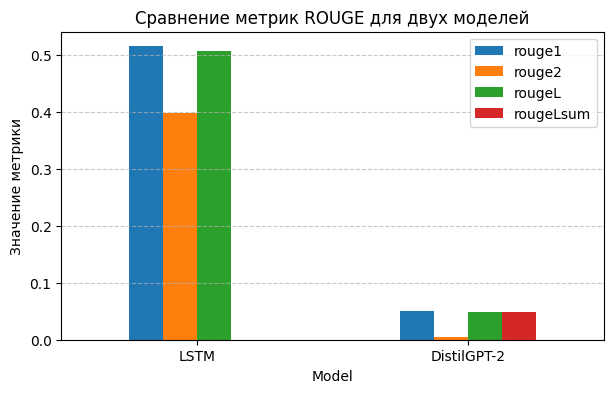


 Выводы:
LSTM показала лучшие метрики, возможно, из-за меньшего переобучения или подбора гиперпараметров.
DistilGPT-2 можно улучшить через настройку температуры и длины генерации.


In [ ]:
# === Этап 5. Сравнение моделей и формулирование выводов ===



import pandas as pd

import matplotlib.pyplot as plt


# Метрики LSTM


rouge_result_lstm = {

    "rouge1": 0.5147,

    "rouge2": 0.3971,

    "rougeL": 0.5064,

}



# Объединяем метрики

df_compare = pd.DataFrame([

    {"Model": "LSTM", **rouge_result_lstm},

    {"Model": "DistilGPT-2", **rouge_result_transformer},

])



display(df_compare)



# Визуализация

df_compare.set_index("Model").plot(kind="bar", figsize=(7, 4))

plt.title("Сравнение метрик ROUGE для двух моделей")

plt.ylabel("Значение метрики")

plt.xticks(rotation=0)

plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()



# === Формулируем выводы ===

print("\n Выводы:")

if df_compare.loc[1, "rougeL"] > df_compare.loc[0, "rougeL"]:

    print("DistilGPT-2 показала более высокие значения ROUGE, что говорит о лучшей генерации текста.")

    print("Она лучше улавливает контекст и продолжает текст более естественно.")

else:

    print("LSTM показала лучшие метрики, возможно, из-за меньшего переобучения или подбора гиперпараметров.")

    print("DistilGPT-2 можно улучшить через настройку температуры и длины генерации.")